In [17]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from scipy import signal
#import time #testing de tiempos
from matplotlib import pyplot as plt
from PIL import Image
#import cProfile #testing de tiempos
from joblib import Parallel, delayed  #multithreading 

In [18]:
# Definir una red neuronal simple
class Model_qm(nn.Module):
    def __init__(self):
        super(Model_qm, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 8)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [19]:
q_m_XOR = Model_qm()
state_dict_XOR = torch.load('q_m_XOR.pth')
q_m_XOR.load_state_dict(state_dict_XOR)
#input must be tensor with float (each bit)
def q_m_XOR_diff(bits):
    return q_m_XOR(bits)

In [20]:
q_m_XNOR = Model_qm()
state_dict_XNOR = torch.load('q_m_XNOR.pth')
q_m_XNOR.load_state_dict(state_dict_XNOR)
#input must be tensor with float (each bit)
def q_m_XNOR_diff(bits):
    return q_m_XNOR(bits)

In [21]:
#input must be float (each bit)
def q_m_diff(input):
    output = torch.tensor([input[0], 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.float32)
    num_1 = torch.sum(input > 0.5)
    if (num_1 > 4) or (num_1 == 4 and input[0] == 0):
        output[:8] = q_m_XNOR_diff(input)
        output[8] = 0
    else:
        output[:8] = q_m_XOR_diff(input)
        output[8] = 1
    return output

In [22]:
#input must be float (each bit) example: [0.0 1.0 1.0 1.0 0.0 0.0 0.0 1.0], 2.0
#output are tensors
def TMDS_diff(pixel_bits,cnt):
    bits_inversos = torch.flip(pixel_bits, dims = (0,))
    #print(bits_inversos)
    #bits_inversos = pixel_bits[::-1]

    ###bits_inversos tiene grad_fn###
    q_m = q_m_diff(bits_inversos)
    ###q_m_diff tiene grad_fn###

    output = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],dtype=torch.float32)
    num_1 = torch.sum(q_m[:8] > 0.5)
    num_0 = torch.sum(q_m[:8] < 0.5)
    IndB = q_m[8] > 0.5
    ###IndB_diff tiene grad_fn###

    IndE = cnt == 0 or (num_1 == num_0)
    ###IndE_diff tiene grad_fn###
    
    IndC = (cnt > 0 and (num_1 > num_0)) or (cnt < 0 and (num_0 > num_1))
    ###IndC_diff tiene grad_fn###

    Neg_q = 1 - q_m

    IndD = q_m[8] < 0.5
    ###InD_diff tiene grad_fn###
    
    if (IndE and IndB) or (not(IndC) and not(IndE)):
        output[:8] = q_m[:8]
    else:
        output[:8] = Neg_q[:8]
    output[8] = q_m[8]
    if IndE:
        output[9] = Neg_q[8]
        if IndD:
            new_cnt = cnt + num_0 - num_1
        else:
            new_cnt = cnt + num_1 - num_0
    else:
        if IndC:
            output[9] = 1
            new_cnt = cnt + 2 * q_m[8] + num_0 - num_1
        else:
            output[9] = 0
            new_cnt = cnt - 2 * Neg_q[8] + num_1 - num_0
    return output,new_cnt

CAMBIOS...

EN FUNCION PIXEL2BIT_DIFF: CAMBIO DEFINICION DE OUTPUT (ANTES LISTA, AHORA TORCH.TENSOR)
EN FUNCION TMDS_DIFF: CAMBIO MODO DE INVERSION DE ARRAY (USANDO TORCH.FLIP)
EN FUNCION QM_DIFF: POR CAMBIOS EN OTRAS FUNCIONES, EL INPUT YA ES UN TORCH.TENSOR

In [23]:
def sigmoid(x):
    x_in = x.clone()
    if x >= 0:
        return 1 / (1 + torch.exp(-x_in))
    else:
        return torch.exp(x_in) / (1 + torch.exp(x_in))

def Pixel2Bit_diff(pixel):
    output = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0], dtype= torch.float32)
    for i in range(1,9):
        output[i-1] = sigmoid(10*(pixel-2**(8-i)+0.5))  # 0.5 para ajustar la sigmoidal
        if pixel >= 2**(8-i):
            pixel = pixel - 2**(8-i)
    return output

In [24]:
#funcion que toma como entrada el armonico a sintonizar y las dimensiones de la imagen a espiar y devuelve un array con taps de g(t)
def g_taps(dim_vertical, dim_horizontal, armonico):

    #defino variables iniciales
    f_b = 10 * (dim_vertical * dim_horizontal * 60)
    f_sdr = 50e6
    harm = armonico * f_b
    
    #para el correcto funcionamiento: dependiendo del armonico, elijo cuantas muestras por pulso
    if (armonico < 5 ):
        muestras_por_pulso  = 10
    else:
        muestras_por_pulso  = 20

    samp_rate = muestras_por_pulso * f_b
    H_samples = dim_horizontal * muestras_por_pulso

    #creo el pulso
    t_continuous = np.linspace(start = 0, stop = H_samples/samp_rate, num = H_samples, endpoint= False)
    pulso = np.zeros(H_samples)
    pulso[:muestras_por_pulso] = 1

    #traslado el espectro del pulso el armonico correspondiente
    frec_armonico = np.exp(-2j*np.pi*harm*t_continuous)
    pulso_complejo = pulso*frec_armonico

    #creo el lpf del sdr
    b, a = signal.butter(6, f_sdr/2, fs=samp_rate, btype='lowpass', analog=False)

    #filtro con lpf el pulso multiplicado por armonico. El resultado es g
    g_t = signal.lfilter(b, a, pulso_complejo)
    g_t = signal.decimate(g_t,q = muestras_por_pulso)

    # si armonico crece, necesito mas taps
    if (armonico < 5):
        g_t = g_t[:170]
    else:
        g_t = g_t[:3000]

    g_t_max = np.max(np.abs(g_t))
 
    g_t = g_t / g_t_max

    return torch.tensor(g_t,dtype = torch.complex64).reshape(1,1,len(g_t))

In [25]:
def TMDS_2_row(multiplicador,cant_filas,img,columnas):
    bits_cod_cant_filas = torch.zeros((1,1,10*columnas*cant_filas),dtype = torch.complex64)
    for i in range(multiplicador*cant_filas, cant_filas*(multiplicador+1)):
        cnt = 0
        bits_cod_fila =  torch.zeros(10*columnas, dtype = torch.complex64)
        for j in range(columnas):
            pixel = img[i,j]
            ###pixel tiene grad_fn ###

            pixel_bits = Pixel2Bit_diff(pixel)
            ###pixel_bits tiene grad_fn ###
            
            pixel_cod,cnt = TMDS_diff(pixel_bits, cnt)
            ###TMDS_diff tiene grad_fn
            #print(pixel_cod)  
            
            bits_cod_fila[j*10:(j+1)*10] = pixel_cod
            ###bits_cod_fila tiene grad_fn
            
        bits_cod_cant_filas[0,0,(10*columnas)*(i-multiplicador*cant_filas):(10*columnas)*((i-multiplicador*cant_filas)+1)] = bits_cod_fila
    return bits_cod_cant_filas

In [26]:
def encontrar_mayor_divisor(a, b): 
    while b != 0:
        a, b = b, a % b
    return a

def Calc_filas_por_thread(filas, threads):  #calculo la max cantidad de filas para que todos calculen la misma cantidad y no sobren filas, para pasarle a cada hilo de forma de optimizar el uso de los hilos. Pasarle de a pocas filas es ineficiente
    divisor = encontrar_mayor_divisor(filas,threads)
    return filas // divisor

In [27]:
def forward(img, armonico, num_threads):
    filas, columnas = img.shape
    g_t = g_taps(filas, columnas, armonico)
    size_g_t = g_t.numel()    
    padding = (size_g_t - 10)//2
    filas_por_thread = Calc_filas_por_thread(filas,num_threads)

    result = Parallel(n_jobs=num_threads)(delayed(TMDS_2_row)(multiplicador,filas_por_thread,img,columnas) for multiplicador in range(num_threads)) # da mejores resultados por poquito el multiprocessing (Pool)
    ###result tiene grad_fn###
    #return result[0]
    if num_threads == 1:
        bits_TMDS = result[0]
    else:
        bits_TMDS = result[0]
        for i in range(1, len(result)):
            bits_TMDS = torch.cat((bits_TMDS, result[i]), dim = 2)
    ###bits_TMDS tiene grad_fn
    #return bits_TMDS
    img_salida = nn.functional.conv1d(bits_TMDS, g_t, stride = 10, padding=padding, bias = None)[0,0,:].reshape((filas,columnas))
    ###img_salida tiene grad_fn###
        
    return img_salida

In [28]:
image_path = '../../images/VAMO!!.png'
img = np.zeros((96,96))
#img = np.asarray(Image.open(image_path))[:,:,0] #solo canal rojo
img_torch = torch.tensor(img, dtype = torch.float32, requires_grad= True)

armonico = 3
num_threads = 1 # elegir numeros de hilos del cpu (dejar alguno libre para que no explote la PC)
#cProfile.runctx('forward(imag,armonico)', globals(), locals()) 
imagen = forward(img_torch, armonico,num_threads)

tensor([[-1.0458e-05+1.7852e-07j,  2.7771e-05-3.9061e-06j,
          5.2324e-04-2.5223e-05j,  ...,
          7.8755e-01+6.7438e-02j, -2.7092e-01+6.0032e-02j,
         -2.8534e-01+5.5735e-02j],
        [ 7.8082e-01+6.7681e-02j, -2.8534e-01+5.5735e-02j,
          7.8082e-01+6.7681e-02j,  ...,
          7.8755e-01+6.7438e-02j, -2.7092e-01+6.0032e-02j,
         -2.8534e-01+5.5735e-02j],
        [ 7.8082e-01+6.7681e-02j, -2.8534e-01+5.5735e-02j,
          7.8082e-01+6.7681e-02j,  ...,
          7.8755e-01+6.7438e-02j, -2.7092e-01+6.0032e-02j,
         -2.8534e-01+5.5735e-02j],
        ...,
        [ 7.8082e-01+6.7681e-02j, -2.8534e-01+5.5735e-02j,
          7.8082e-01+6.7681e-02j,  ...,
          7.8755e-01+6.7438e-02j, -2.7092e-01+6.0032e-02j,
         -2.8534e-01+5.5735e-02j],
        [ 7.8082e-01+6.7681e-02j, -2.8534e-01+5.5735e-02j,
          7.8082e-01+6.7681e-02j,  ...,
          7.8755e-01+6.7438e-02j, -2.7092e-01+6.0032e-02j,
         -2.8534e-01+5.5735e-02j],
        [ 7.8082e-01+6

In [29]:
imagen.backward(gradient=torch.ones_like(imagen),retain_graph=True)
#imagen.backward()

In [30]:
print(img_torch.grad)

None


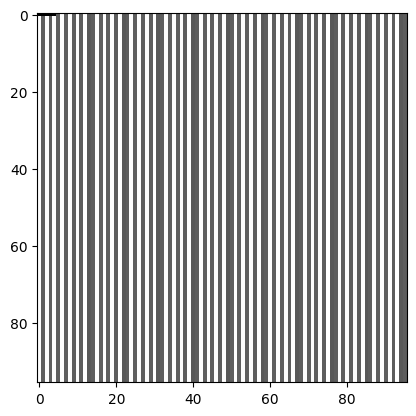

In [31]:
img_sim = np.abs(imagen.detach().numpy())

plt.figure()
plt.imshow(255*((img_sim - img_sim.min())/(img_sim.max()-img_sim.min())),cmap='gray')
plt.show()